System Design:
- Given a user input, use a grapheme-phoneme model to get native speaker phoneme sequence
- Use a ASR model trained on L2 Artic to get phoneme sequence from L2 utterance
  - Finetune Wav2Vec2.0 on L2 Artic Korean, Mandarin and Vietnamese Speakers so 12 speakers compared to 1 speaker
- Identify the phonemes that have errors by comparing to native speaker phoneme sequence
- Map the phoneme sequence back to the word level annotations to get WER
- Conduct testing

Sources:
- https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2
- https://huggingface.co/blog/fine-tune-wav2vec2-english
- https://huggingface.co/blog/fine-tune-xlsr-wav2vec2

# Exploring L2 Artic

L2 artic dataset contains audio and labels from L2 speakers of different countries e.g. "YDCK" is a female from Korea.


For each speaker, the corpus
contains the following data:
• Speech recordings: over one hour of prompted recordings
of phonetically-balanced short sentences
• Word level transcriptions: orthographic transcription and
forced-aligned word boundaries for each sentence
• Phoneme level transcriptions: forced-aligned phoneme
transcription for each sentence
• Manual annotations: a selected subset of utterances (~150),
including 100 sentences produced by all speakers and 50
sentences that include phonemes likely to be difficult
according to each speaker’s L1, all annotated with corrected
word and phone boundaries; phone substitution, deletion,
and addition errors are also tagged

- Wav folder --  Containing audio files in WAV format, sampled at 44.1 kHz
  - The rule of thumb is that as long as there exists an audio file for a sentence, there will be an accompanying orthographic transcription (Transcript Folder) and a forced-aligned phoneme transcription (Textgrid Folder). BUT, it may not have corresponding manual error annotations.

- Transcript folder -- contains the text read by speaker in txt format

- Textgrid folder -- Containing word and phoneme transcriptions generated from forced-alignment in textgrid format -- aka how it should be pronounced natively

- Annotations folder -- contains a textgrid file with 3 tiers of MANUAL annotations -- word level, phone level and other comments from annotator e.g. sound quality issue etc
  - a selected subset of utterances (~150), including 100 sentences produced by all speakers and 50 sentences that include phonemes likely to be difficult according to each speaker’s L1, all annotated with corrected word and phone boundaries; phone substitution, deletion, and addition errors are also tagged

The difference between the content in textgrid folder and annotations folder is that the annotations folder contains more notes about the pronounciation errors
  - For phone substitution error, the annotation is "CPL, PPL, s"
  - For phone addition error, the annotation is "sil, PPL, a"
  - For phone deletion error, the annotation is "CPL, sil, d"

CPL is the correct phoneme AKA how it should have been pronounced

PPL is the perceived phoneme
  - Special labels: "sil" for silence, "err" if not in American English phoneme set and deviation mark * added if it is American English phoneme with foreign accent e.g. "A0*"

 s/a/d represents the respective errors


In [ ]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install textgrid
!pip install jiwer
!pip install phonemizer
!pip install streamlit
!pip install torchaudio
!pip install speechbrain

In [ ]:
!python --version

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
WORKING_PATH = '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments'
DATA_PATH = os.path.join(WORKING_PATH, "l2 artic dataset split")
ANNOTATIONS_FOLDER_NAME = "annotation"
WAV_FOLDER_NAME = "wav"
TRANSCRIPT_FOLDER_NAME = "transcript" # in textgrid format
TEXTGRID_FOLDER_NAME = "textgrid" # in textgrid format
SPEAKERS = glob.glob(os.path.join(DATA_PATH, "*", "*"))
VOCAB_JSON_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'wav2vec2_vocab_full.json')
DATASET_DICT_JSON_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'wav2vec2_dataset_full.json')
VOCAB_JSON_NO_LEXICAL_STRESS_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'wav2vec2_vocab_no_lexical_stress.json')
DATASET_DICT_JSON_NO_LEXICAL_STRESS_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'wav2vec2_dataset_no_lexical_stress.json')
TRAIN_DATASET_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'train_dataset_no_lexical_stress')
TEST_DATASET_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'test_dataset_no_lexical_stress')
MODEL_CHECKPOINTS_DIRECTORY = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2", "wav2vec-baseline2-model-checkpoints")
BEST_MODEL_PATH = os.path.join('/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project', 'Checkpoints', 'multitask_best_ctc.pt')
BEST_MODEL_VOCAB_PATH = os.path.join('/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project', 'Checkpoints', 'vocab')

# Data Exploration

To create the corpus, 1,132 sentences in the CMU
ARCTIC prompts were used. There were multiple reasons to choose these
sentences. First, the ARCTIC prompts are phonetically
balanced (100%, 79.6%, and 13.7% coverage for phonemes,
diphones, and triphones, respectively), are open source, and can
produce around one hour of edited speech. Second, the
ARCTIC corpus itself has proven to work well with speech
synthesis and voice conversion tasks. Finally,
the ARCTIC prompts are challenging for non-native English
speakers so they can elicit potential pronunciation problems.

Source: https://www.isca-speech.org/archive/pdfs/interspeech_2018/zhao18b_interspeech.pdf

## What is the average duration of each utterance?
On average, each utterance is 3.7 seconds in duration. The pause
before and after each utterance is generally no longer than 100
ms.

## How are the words distributed?

The dataset contains over 97,000 word segments, giving an average of
around nine words per utterance

## How are the errors distributed?
No error: 57431

Substitution: 7146

Insertion: 509

Deletion: 2465

For test only: No error: 11477, Substitution: 1457, Deletion: 493, and Insertion: 100

## How are the phonemes distributed?
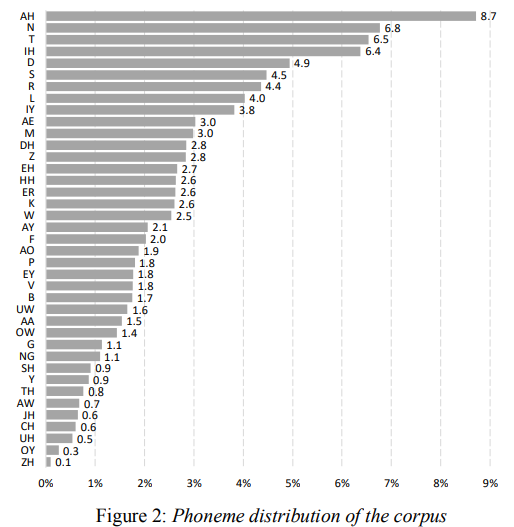

## What are the most frequent errors by native language?
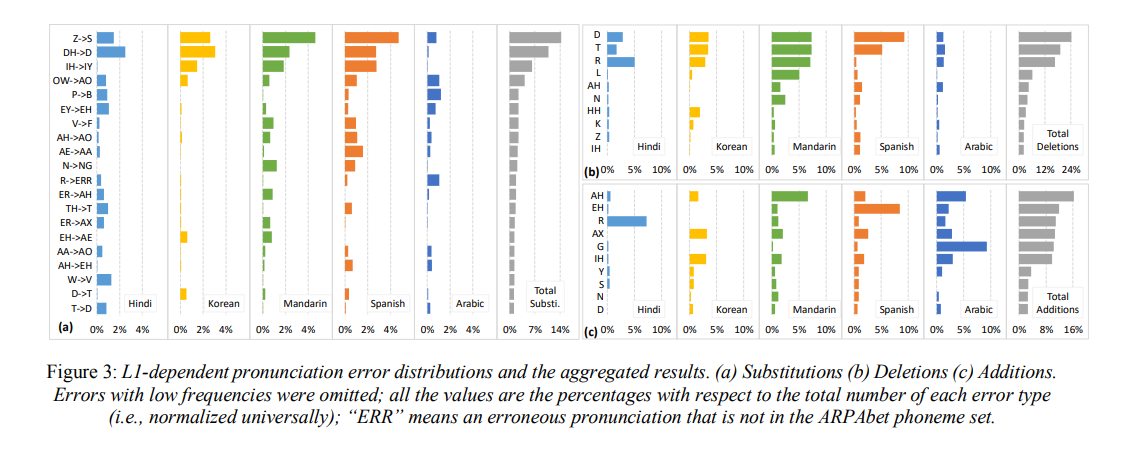

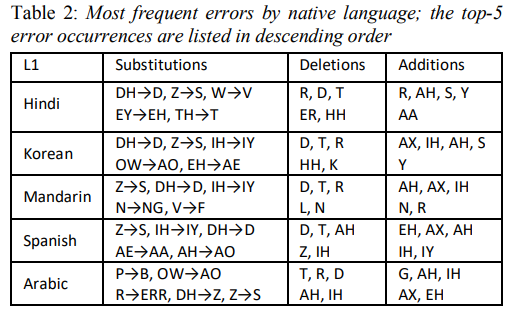

Create a processing function to get the annotations out of TextGrid file in Annotations folder. For baseline V1, we will only use the pronounced_phones / phoneme transcriptions of L2 speaker


Since L2-ARCTIC uses artificial sil tokens to represent phoneme deletions and insertions, to construct target training phoneme sequences, we need to remove the artificial sil tokens, while preserving the sil tokens that
correspond to true pauses and silences

Cases:
- For phone addition error, the annotation is "sil, PPL, a" --> this is okay since we are just focused on what the L2 speaker said aka PPL
- For phone deletion error, the annotation is "CPL, sil, d" --> this artificial silence means that L2 speaker missed out on a phoneme rather than the speaker paused

In [ ]:
import textgrid

def get_phones_annotation_data(textgrid_filepath):
  """
  Ignores the word and IPA annotations -- with word annotations, it is possible to add word delimiters
  Ignores the start and end time annotations
  Outputs a dictionary containing the list of correct phonemes (how the text should have been pronounced natively),
  pronouned_phones (how the text was pronouned by L2 speaker) and a list of errors (substition, addition or deletion) corresponding
  to index of phones
  """
  tg_dict = {"correct_phones":[], "pronounced_phones":[], "errors":[]}
  try:
    tg = textgrid.TextGrid.fromFile(textgrid_filepath)
  except:
    print("Error loading textgrid file")
    return
  for interval_tier in tg:
    if interval_tier.name != "phones":
      continue
    results = []
    for interval in interval_tier:
      start_time = interval.minTime
      end_time = interval.maxTime
      annotation = interval.mark
      if annotation == "":
        annotation = "sil"
      if "," in annotation:
        # either s,a or d pronounciation error by L2 speaker
        correct_phoneme, detected_phoneme, error_type = annotation.split(",")
        # we do not add the artificial sil token for L2 speaker in the case of phone deletion
        if error_type.strip() != "d":
          tg_dict["pronounced_phones"].append(detected_phoneme.strip())
        tg_dict["correct_phones"].append(correct_phoneme.strip())
        tg_dict["errors"].append(error_type.strip())
      else:
        # l2 speaker pronounced correctly -- so annotation is just a phone e.g. "AH"
        tg_dict["correct_phones"].append(annotation)
        tg_dict["pronounced_phones"].append(annotation)
        tg_dict["errors"].append("")

  return tg_dict

Explore what is the distribution of errors in the manual annotations

In [ ]:
# What are the counts of each error in our subset of data?
speaker_list = [path.split("/")[-1] for path in SPEAKERS]
error_dict = {speaker: {"error":[]} for speaker in speaker_list}
for speaker_path in SPEAKERS:
  print(speaker_path)
  error_list = []
  manual_annotations = []
  # manual_annotations.extend(glob.glob(os.path.join(speaker_path, "train", ANNOTATIONS_FOLDER_NAME, "*.TextGrid")))
  manual_annotations.extend(glob.glob(os.path.join(speaker_path, "test", ANNOTATIONS_FOLDER_NAME, "*.TextGrid")))
  for annotation_path in manual_annotations:
    phone_annotation_data = get_phones_annotation_data(annotation_path)
    if phone_annotation_data:
      errors = phone_annotation_data["errors"]
      error_list.append(errors)
  print(len(error_list))
  error_dict[speaker_path.split("/")[-1]]["error"] = error_list


/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/NCC
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/LXC
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/TXHC
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/BWC
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/TLV
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/PNV
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/HQTV
30
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/THV
3

In [ ]:
from collections import Counter
all_errors = []
for speaker, annotations in error_dict.items():
  for errors in annotations["error"]:
    all_errors.extend([e.lower().strip() for e in errors])
Counter(all_errors)

Counter({'': 57431, 's': 7146, 'a': 509, 'd': 2465})

Create a processing function to get phonetic transcriptions out of the the TextGrid Folder

Note, as not all audio has manual error annotations, we will use the TextGrid folder's phonetic transcriptions in those cases without the error annotations

In [ ]:
def get_phonetic_transcription_data(textgrid_filepath):
  tg_dict = {"pronounced_phones":[]}
  try:
    tg = textgrid.TextGrid.fromFile(textgrid_filepath)
  except:
    print("Error loading textgrid file")
    return

  for interval_tier in tg:
    if interval_tier.name != "phones":
      continue
    results = []
    for interval in interval_tier:
      start_time = interval.minTime
      end_time = interval.maxTime
      annotation = interval.mark
      if annotation == "":
        annotation = "sil"

      tg_dict["pronounced_phones"].append(annotation)

  return tg_dict

Combine all the information into a dictionary -- each key is the speaker and the value is a dictionary representing column_name:values

We store the str path to wav file (converted to array of samples later with Huggingface dataset package), the str transcript of the audio and the phone-level annotations as lists

In [ ]:
speaker_list = [path.split("/")[-1] for path in SPEAKERS]
speaker_list

['NCC',
 'LXC',
 'TXHC',
 'BWC',
 'TLV',
 'PNV',
 'HQTV',
 'THV',
 'YDCK',
 'YKWK',
 'HJK',
 'HKK']

In [ ]:
dataset_dict = {speaker:{"audio":[], "transcript":[],"pronounced_phones":[]} for speaker in speaker_list}

for speaker_path in SPEAKERS:
  speaker = speaker_path.split("/")[-1]
  print(speaker)

  WAV_PATH = os.path.join(speaker_path, "train", WAV_FOLDER_NAME)
  TRANSCRIPT_PATH = os.path.join(speaker_path, "train", TRANSCRIPT_FOLDER_NAME)
  ANNOTATIONS_PATH = os.path.join(speaker_path, "train", ANNOTATIONS_FOLDER_NAME)
  TEXTGRID_PATH = os.path.join(speaker_path,"train", TEXTGRID_FOLDER_NAME)

  print(f"Number of audio files: {len(os.listdir(WAV_PATH))}")
  manual_annotation_count = 0

  for wav_filename in os.listdir(WAV_PATH):
    audio_path = os.path.join(WAV_PATH, wav_filename)
    # -4 to remove ".wav"
    transcript_path = os.path.join(TRANSCRIPT_PATH, wav_filename[:-4] + ".txt")
    annotation_path = os.path.join(ANNOTATIONS_PATH, wav_filename[:-4] + ".TextGrid")
    textgrid_path = os.path.join(TEXTGRID_PATH, wav_filename[:-4] + ".TextGrid")

    with open(transcript_path) as f:
      contents = f.read()
    f.close()

    phone_annotation = None

    if os.path.exists(annotation_path): # manual annotations are rare
      phone_annotation = get_phones_annotation_data(annotation_path)
      manual_annotation_count += 1
      print("Manual annotation added")

    # we use force alignment transcriptions if there are no manual annotations
    if phone_annotation == None:
      phone_annotation = get_phonetic_transcription_data(textgrid_path)

    pronounced_phones = phone_annotation["pronounced_phones"]

    dataset_dict[speaker]["audio"].append(audio_path)
    dataset_dict[speaker]["transcript"].append(contents)
    dataset_dict[speaker]["pronounced_phones"].append(pronounced_phones)

  print(f"Manual annotation count: {manual_annotation_count}")

For baseline, we will only end up using the audio and pronounced_phones columns


In [ ]:
sample = dataset_dict["NCC"]
print(len(sample["audio"]))
for key in sample.keys():
  print(f"{key}: {sample[key][0]}")

905
audio: /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/NCC/train/wav/arctic_a0459.wav
transcript: There's too much of the schoolboy in me
pronounced_phones: ['sil', 'D', 'EH1', 'R', 'S', 'T', 'UW1', 'M', 'AH1', 'CH', 'AH1', 'V', 'D', 'AH1', 'S', 'K', 'UW1', 'B', 'OY2', 'IH1', 'NG', 'M', 'IY1', 'sp', 'sil']


For the case of the HuggingFace Wav2Vec tokenizer, we will join the list of phonemes to a string and save this to the "target_text" column

In [ ]:
for speaker, values in dataset_dict.items():
  phoneme_lists = values["pronounced_phones"]
  phoneme_strings = ["|".join(phoneme_list) for phoneme_list in phoneme_lists]
  dataset_dict[speaker]["target_text"] = phoneme_strings

sample = dataset_dict["NCC"]
print(len(sample["audio"]))
for key in sample.keys():
  print(f"{key}: {sample[key][0]}")

905
audio: /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/NCC/train/wav/arctic_a0459.wav
transcript: There's too much of the schoolboy in me
pronounced_phones: ['sil', 'D', 'EH1', 'R', 'S', 'T', 'UW1', 'M', 'AH1', 'CH', 'AH1', 'V', 'D', 'AH1', 'S', 'K', 'UW1', 'B', 'OY2', 'IH1', 'NG', 'M', 'IY1', 'sp', 'sil']
target_text: sil|D|EH1|R|S|T|UW1|M|AH1|CH|AH1|V|D|AH1|S|K|UW1|B|OY2|IH1|NG|M|IY1|sp|sil


Save the dataset into JSON

In [ ]:
import json
with open(DATASET_DICT_JSON_PATH, 'w') as file:
  json.dump(dataset_dict,file)

In [ ]:
import json
f = open(DATASET_DICT_JSON_PATH)
data = json.load(f)

In [ ]:
text_annotations = data["NCC"]["transcript"]
len(text_annotations)

905

In [ ]:
text_annotations[0]

"There's too much of the schoolboy in me"

In [ ]:
import json

PROMPTS_JSON_PATH = os.path.join(WORKING_PATH, "Wav2Vec Baselines", "L2 Artic 3 Speakers: Baseline 2",'prompts.json')
with open(PROMPTS_JSON_PATH, 'w') as file:
  json.dump({"prompts":text_annotations},file)

In [ ]:
print(PROMPTS_JSON_PATH)

/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/prompts.json


We create a vocabulary dictionary AKA all the prediction classes
- Note that we are including accented phonemes (with * deviation marker), the "err" phoneme for foreign language phonemes and phonemes with lexical stress e.g. "AH0" and "AY1" as denoted by the number

In [ ]:
def flatten_extend(matrix):
  flat_list = []
  for row in matrix:
    flat_list.extend(row)
  return flat_list

pronounced_phonemes = []
for key, values in dataset_dict.items():
  pronounced_phonemes.extend(list(set(flatten_extend(values["pronounced_phones"]))))

unique_pronounced_phonemes = list(set(pronounced_phonemes))

id_to_label_dict = dict(enumerate(unique_pronounced_phonemes))
vocab_dict = {label:id for id, label in id_to_label_dict.items()}
vocab_dict["|"] = len(vocab_dict) # word delimiter
vocab_dict["[UNK]"] = len(vocab_dict) # unknown token
vocab_dict["[PAD]"] = len(vocab_dict) # blank token for CTC
len(vocab_dict), vocab_dict

(130,
 {'OW2': 0,
  'K*': 1,
  'Z*': 2,
  'AE*': 3,
  'AY2': 4,
  'B': 5,
  'UH*': 6,
  'AY1': 7,
  'W': 8,
  'EH2': 9,
  'AH1': 10,
  'SIL': 11,
  'AH0': 12,
  'AA*1': 13,
  'CH': 14,
  'EH*': 15,
  'T': 16,
  'IH2': 17,
  'D_': 18,
  'W*': 19,
  'K': 20,
  'UH1': 21,
  'spn': 22,
  'AH': 23,
  'AH2': 24,
  'AH*': 25,
  'NG': 26,
  'AW0': 27,
  'P*': 28,
  'B*': 29,
  'OW1': 30,
  'G': 31,
  'OY': 32,
  'IH1': 33,
  'EH0': 34,
  'AW2': 35,
  'AE2': 36,
  'OW0': 37,
  'D': 38,
  'ZH': 39,
  'sp': 40,
  'V': 41,
  'EY': 42,
  'V``': 43,
  'EY1': 44,
  'UW': 45,
  's': 46,
  'P': 47,
  'ER0': 48,
  'UW*': 49,
  'ER*': 50,
  'AE1': 51,
  'sil': 52,
  'R*': 53,
  'UH0': 54,
  'IH': 55,
  'EY0': 56,
  'OW': 57,
  'HH*': 58,
  'OY0': 59,
  'Y': 60,
  'AO': 61,
  'IY0': 62,
  'AW*': 63,
  'ER': 64,
  'OW*': 65,
  'ER2': 66,
  'AY': 67,
  'M': 68,
  'ER1': 69,
  'AY0': 70,
  'AA1': 71,
  'T*': 72,
  'AW1': 73,
  'DH': 74,
  'AA*': 75,
  'IY1': 76,
  'L': 77,
  'EH1': 78,
  'UW1': 79,
  'AA2': 

In [ ]:
import json
with open(VOCAB_JSON_PATH, 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

Another option: Edit data to remove lexical stress markers so as to reduce amount of prediction classes for training

Lexical stress may not affect intelligiblity -- it affects accent more

In [ ]:
import re
dataset_dict_updated = {speaker: {} for speaker in speaker_list}
# as we are framing MD as phoneme recognition problem, we only need the transcripted phonemes and audio
for speaker, values in dataset_dict.items():
  phonemes_without_lexical_stress = [re.sub(r'\d', "", phone_str) for phone_str in values["target_text"]]
  dataset_dict_updated[speaker]["target_text"] = phonemes_without_lexical_stress
  dataset_dict_updated[speaker]["audio"] = values["audio"]

sample = dataset_dict_updated["NCC"]
for key in sample.keys():
  print(f"{key}: {sample[key][0]}")

target_text: sil|D|EH|R|S|T|UW|M|AH|CH|AH|V|D|AH|S|K|UW|B|OY|IH|NG|M|IY|sp|sil
audio: /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/NCC/train/wav/arctic_a0459.wav


In [ ]:
pronounced_phonemes = []
for speaker, values in dataset_dict_updated.items():
  for phoneme_str in values["target_text"]:
    pronounced_phonemes.extend(phoneme_str.split("|"))
unique_pronounced_phonemes = list(set(pronounced_phonemes))
id_to_label_dict = dict(enumerate(unique_pronounced_phonemes))
vocab_dict_updated = {label:id for id, label in id_to_label_dict.items()}

vocab_dict_updated["|"] = len(vocab_dict_updated) # word delimiter
vocab_dict_updated["[UNK]"] = len(vocab_dict_updated) # unknown token
vocab_dict_updated["[PAD]"] = len(vocab_dict_updated) # blank token for CTC
len(vocab_dict_updated), vocab_dict_updated

(83,
 {'K*': 0,
  'Z*': 1,
  'AE*': 2,
  'B': 3,
  'UH*': 4,
  'W': 5,
  'SIL': 6,
  'CH': 7,
  'EH*': 8,
  'T': 9,
  'D_': 10,
  'W*': 11,
  'K': 12,
  'spn': 13,
  'AH': 14,
  'AH*': 15,
  'NG': 16,
  'P*': 17,
  'B*': 18,
  'G': 19,
  'OY': 20,
  'D': 21,
  'ZH': 22,
  'sp': 23,
  'V': 24,
  'EY': 25,
  'V``': 26,
  'UW': 27,
  's': 28,
  'P': 29,
  'UW*': 30,
  'ER*': 31,
  'sil': 32,
  'R*': 33,
  'IH': 34,
  'OW': 35,
  'HH*': 36,
  'Y': 37,
  'AO': 38,
  'AW*': 39,
  'ER': 40,
  'OW*': 41,
  'AY': 42,
  'M': 43,
  'T*': 44,
  'DH': 45,
  'AA*': 46,
  'L': 47,
  'AX': 48,
  'N*': 49,
  'EH': 50,
  'DH*': 51,
  't': 52,
  'ERR': 53,
  'AO*': 54,
  'Z': 55,
  'S': 56,
  'ZH*': 57,
  'EY*': 58,
  'JH*': 59,
  'F': 60,
  'L*': 61,
  'Y*': 62,
  'R': 63,
  'G*': 64,
  'JH': 65,
  'W`': 66,
  'D*': 67,
  'AA': 68,
  'IY': 69,
  'AE': 70,
  'Ah': 71,
  'AW': 72,
  'SH': 73,
  'TH': 74,
  'N': 75,
  'V*': 76,
  'HH': 77,
  'UH': 78,
  'err': 79,
  '|': 80,
  '[UNK]': 81,
  '[PAD]': 82})

In [ ]:
import json
with open(DATASET_DICT_JSON_NO_LEXICAL_STRESS_PATH, 'w') as file:
  json.dump(dataset_dict_updated,file)

with open(VOCAB_JSON_NO_LEXICAL_STRESS_PATH, 'w') as vocab_file:
    json.dump(vocab_dict_updated, vocab_file)

Convert the dictionary to HuggingFace dataset
  - Wav file in audio path will be read and converted to an array of samples

We saved the data into JSON files -- we will do some further processing to reduce the number of prediction classes

Wav2Vec2 was pretrained on the audio data of LibriSpeech and LibriVox which both were sampling with 16kHz. Note that our finetuning dataset, L2 Artic, has audio sampled at 44.1 kHz so we first would have to downsample the speech signal to match the sampling rate of the data used for pretraining.

In [ ]:
import json

f = open(VOCAB_JSON_NO_LEXICAL_STRESS_PATH)
vocab_dict_updated = json.load(f)

f = open(DATASET_DICT_JSON_NO_LEXICAL_STRESS_PATH)
dataset_dict = json.load(f)

In [ ]:
# we need to flatten dataset_dict to just a dictionary with {'target_text', 'audio'}

dataset_dict_updated = {"target_text":[], "audio":[]}

for speaker, values in dataset_dict.items():
  print(speaker, values.keys())
  dataset_dict_updated["target_text"].extend(values["target_text"])
  dataset_dict_updated["audio"].extend(values["audio"])

print("Updated format")
for key, values in dataset_dict_updated.items():
  print(key, values[0])

NCC dict_keys(['target_text', 'audio'])
LXC dict_keys(['target_text', 'audio'])
TXHC dict_keys(['target_text', 'audio'])
BWC dict_keys(['target_text', 'audio'])
TLV dict_keys(['target_text', 'audio'])
PNV dict_keys(['target_text', 'audio'])
HQTV dict_keys(['target_text', 'audio'])
THV dict_keys(['target_text', 'audio'])
YDCK dict_keys(['target_text', 'audio'])
YKWK dict_keys(['target_text', 'audio'])
HJK dict_keys(['target_text', 'audio'])
HKK dict_keys(['target_text', 'audio'])
Updated format
target_text sil|D|EH|R|S|T|UW|M|AH|CH|AH|V|D|AH|S|K|UW|B|OY|IH|NG|M|IY|sp|sil
audio /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/NCC/train/wav/arctic_a0459.wav


In [ ]:
import datasets
l2_artic_dataset = datasets.Dataset.from_dict(dataset_dict_updated).cast_column("audio", datasets.features.audio.Audio(sampling_rate=16000))
l2_artic_dataset

Dataset({
    features: ['target_text', 'audio'],
    num_rows: 10864
})

Setting up Wav2Vec2.0 tokenizer, feature extractor and processor


In [ ]:
from transformers import Wav2Vec2CTCTokenize, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
tokenizer = Wav2Vec2CTCTokenizer(VOCAB_JSON_NO_LEXICAL_STRESS_PATH, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
test_phoneme_str = "sil|AY|M|P|L|EY"
with processor.as_target_processor():
  sample_labels = processor(test_phoneme_str).input_ids
# remove the word delimiter token
decoded_phonemes = [phoneme for phoneme in tokenizer.batch_decode(sample_labels) if phoneme]
sample_labels, decoded_phonemes

([32, 80, 42, 80, 43, 80, 29, 80, 47, 80, 25],
 ['sil', 'AY', 'M', 'P', 'L', 'EY'])

Train Test Split

In [ ]:
l2_artic_dataset = l2_artic_dataset.train_test_split(test_size=0.2)
l2_artic_dataset

DatasetDict({
    train: Dataset({
        features: ['target_text', 'audio'],
        num_rows: 8691
    })
    test: Dataset({
        features: ['target_text', 'audio'],
        num_rows: 2173
    })
})

In [ ]:
train_dataset = l2_artic_dataset["train"]
test_dataset = l2_artic_dataset["test"]

Prepare dataset

In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [ ]:
train_dataset = train_dataset.map(prepare_dataset)
test_dataset = test_dataset.map(prepare_dataset)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
train_dataset.save_to_disk(TRAIN_DATASET_PATH)
test_dataset.save_to_disk(TEST_DATASET_PATH)

We only need the input_values and labels columns

Set up trainer

In [ ]:
import datasets

train_dataset_loaded = datasets.load_from_disk(TRAIN_DATASET_PATH)
test_dataset_loaded = datasets.load_from_disk(TEST_DATASET_PATH)

In [ ]:
train_dataset_final = train_dataset_loaded.remove_columns(['audio', 'target_text'])
test_dataset_final = test_dataset_loaded.remove_columns(['audio', 'target_text'])
train_dataset_final, test_dataset_final

(Dataset({
     features: ['input_values', 'labels'],
     num_rows: 8691
 }),
 Dataset({
     features: ['input_values', 'labels'],
     num_rows: 2173
 }))

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the group_tokens=False parameter has to be passed. If we wouldn't pass this parameter a word like "hello" would incorrectly be encoded, and decoded as "helo".

In [ ]:
from datasets import load_metric
import jiwer
import numpy as np
def compute_metrics(pred):
  pred_logits = pred.predictions
  pred_ids = np.argmax(pred_logits, axis=-1)
  pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

  pred_phones = [phoneme for phoneme in tokenizer.batch_decode(pred_ids)]
  label_phones = [phoneme for phoneme in tokenizer.batch_decode(pred.label_ids, group_tokens=False)]
  pred_str = " ".join(pred_phones)
  label_str = " ".join(label_phones)

  per = jiwer.wer(pred_str,label_str)

  return {
      "per": per
  }

In [ ]:
# testing
pred_ids = [9,26]
label_ids = [9,27]
pred_phones = [phoneme for phoneme in tokenizer.batch_decode(pred_ids)]
label_phones = [phoneme for phoneme in tokenizer.batch_decode(label_ids, group_tokens=False)]
pred_str = " ".join(pred_phones)
label_str = " ".join(label_phones)
per = jiwer.wer(pred_str,label_str)
print(f"PER: {per}")

out = jiwer.process_words(pred_str, label_str)
print(jiwer.visualize_alignment(out))

PER: 0.5
sentence 1
REF: T V`
HYP: T UW
        S

number of sentences: 1
substitutions=1 deletions=0 insertions=0 hits=1

mer=50.00%
wil=75.00%
wip=25.00%
wer=50.00%



In [ ]:
from transformers import Wav2Vec2ForCTC

base_model_path = "facebook/wav2vec2-xls-r-300m"
model = Wav2Vec2ForCTC.from_pretrained(
    base_model_path,
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.75,
    mask_time_length=10,
    mask_feature_prob=0.25,
    mask_feature_length=64,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'project_q.bias', 'quantizer.weight_proj.bias', 'project_hid.weight', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it 

Load model from pretrained checkpoint

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the paper does not need to be fine-tuned anymore. Thus, we can set the requires_grad to False for all parameters of the feature extraction part.

In [ ]:
model.freeze_feature_encoder()

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

# 70
training_args = TrainingArguments(
  output_dir=MODEL_CHECKPOINTS_DIRECTORY,
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=40,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  load_best_model_at_end = True,
  metric_for_best_model = 'per'
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_final,
    eval_dataset=test_dataset_final,
    tokenizer=processor.feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)


Using amp half precision backend


In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (right mouse click -> inspect -> Console tab and insert code).

<code>
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
</code>

In [ ]:
trainer.train(resume_from_checkpoint = True)

Loading model from /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-600).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8691
  Num Epochs = 40
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 10880
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 600
  Will skip the first 2 epochs then the first 112 batches in the first epoch. If th

  0%|          | 0/112 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Per
800,0.943300,0.413869,0.256585
1000,0.884200,0.396223,0.249803
1200,0.854200,0.378477,0.240036


***** Running Evaluation *****
  Num examples = 2173
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-800
Configuration saved in /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-800/config.json
Model weights saved in /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-800/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-800/preprocessor_config.json
Deleting older checkpoint [/con

TrainOutput(global_step=1200, training_loss=0.44696393330891926, metrics={'train_runtime': 4936.8082, 'train_samples_per_second': 70.418, 'train_steps_per_second': 2.204, 'total_flos': 4.4309288969819863e+18, 'train_loss': 0.44696393330891926, 'epoch': 4.41})

In [ ]:
trainer.evaluate(train_dataset_final)

***** Running Evaluation *****
  Num examples = 8691
  Batch size = 8


{'eval_loss': 1.956978440284729,
 'eval_per': 17.47209757220113,
 'eval_runtime': 562.1321,
 'eval_samples_per_second': 15.461,
 'eval_steps_per_second': 1.934,
 'epoch': 2.21}

In [ ]:
trainer.evaluate(test_dataset_final)

***** Running Evaluation *****
  Num examples = 2173
  Batch size = 8


{'eval_loss': 1.9543204307556152,
 'eval_per': 17.541647491946616,
 'eval_runtime': 141.8179,
 'eval_samples_per_second': 15.322,
 'eval_steps_per_second': 1.918,
 'epoch': 2.21}

In [ ]:
path = os.path.join(MODEL_CHECKPOINTS_DIRECTORY, "checkpoint-1200")
tokenizer.save_pretrained(path)

('/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-1200/tokenizer_config.json',
 '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-1200/special_tokens_map.json',
 '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-1200/vocab.json',
 '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2/wav2vec-baseline2-model-checkpoints/checkpoint-1200/added_tokens.json')

# Demo

Rationale for using a G2P model instead of CMUDICT:

Unlike many languages like Spanish or German where pronunciation of a word can be inferred from its spelling, English words are often far from people’s expectations. Therefore, it will be the best idea to consult a dictionary if we want to know the pronunciation of some word. However, there are at least two tentative issues in this approach. First, you can’t disambiguate the pronunciation of homographs, words which have multiple pronunciations. (See a below.) Second, you can’t check if the word is not in the dictionary. (See b below.)

a. Heteronyms represent words that have the same spelling but different pronunciations, e.g., “read” in “I will read the book.” vs. “She read her project last week.”

b. I am an activationist. (activationist: newly coined word which means n. A person who designs and implements programs of treatment or therapy that use recreation and activities to help people whose functional abilities are affected by illness or disability)



Source: https://pypi.org/project/g2p-en/

In [ ]:
from pandas.core.construction import T
import torch
import jiwer
import re

class MispronounciationDetector:
  def __init__(self, l2_phoneme_recogniser, g2p, device):
    self.phoneme_asr_model = l2_phoneme_recogniser # PhonemeASRModel class
    self.g2p = g2p
    self.device = device

  def detect(self, audio, text):
    l2_phones = self.phoneme_asr_model.get_l2_phoneme_sequence(audio)
    l2_phones = [re.sub(r'\d', "", phone_str) for phone_str in l2_phones] #g2p has no lexical stress
    native_speaker_phones = self.get_native_speaker_phoneme_sequence(text)
    try:
      standardised_native_speaker_phones = self.phoneme_asr_model.standardise_g2p_phoneme_sequence(native_speaker_phones)
    except:
      standardised_native_speaker_phones = native_speaker_phones
    raw_info = self.get_mispronounciation_output(text, l2_phones, standardised_native_speaker_phones)
    return raw_info

  def get_native_speaker_phoneme_sequence(self, text):
    phonemes = self.g2p(text)
    return phonemes

  def get_mispronounciation_output(self, text, pred_phones, org_label_phones):
    """
    Aligns the predicted phones from the L2 speaker and the expected native speaker phone to get the errors
    :param text: original words read by the user
    :type text: string
    :param pred_phones: predicted phonemes by L2 speaker from ASR Model
    :type pred_phones: array
    :param org_label_phones: correct, native speaker phonemes from G2P where phonemes of each word is segregated by " "
    :type org_label_phones: array
    :return: dictionary containing various mispronounciation information like PER, WER and error boolean arrays at phoneme/word level
    :rtype: dictionary
    """
    # get per
    label_phones = [phone for phone in org_label_phones if phone != " "]
    reference = " ".join(label_phones) # dummy phones
    hypothesis = " ".join(pred_phones) # dummy l2 speaker phones
    res = jiwer.process_words(reference, hypothesis)
    per = res.wer
    # print(jiwer.visualize_alignment(res))

    # get phoneme alignments
    alignments = res.alignments
    error_bool = []
    ref, hyp = [],[]
    for alignment_chunk in alignments[0]:
      alignment_type = alignment_chunk.type
      ref_start_idx = alignment_chunk.ref_start_idx
      ref_end_idx = alignment_chunk.ref_end_idx
      hyp_start_idx = alignment_chunk.hyp_start_idx
      hyp_end_idx = alignment_chunk.hyp_end_idx
      if alignment_type != "equal":
        if alignment_type == "insert":
          for i in range(hyp_start_idx, hyp_end_idx):
            ref.append("*" * len(pred_phones[i]))
            space_padding = " " * (len(pred_phones[i])-1)
            error_bool.append(space_padding + "a")
          hyp.extend(pred_phones[hyp_start_idx:hyp_end_idx])
        elif alignment_type == "delete":
          ref.extend(label_phones[ref_start_idx:ref_end_idx])
          for i in range(ref_start_idx, ref_end_idx):
            hyp.append("*" * len(label_phones[i]))
            space_padding = " " * (len(label_phones[i])-1)
            error_bool.append(space_padding + alignment_type[0])
        else:
          for i in range(ref_end_idx - ref_start_idx):
            correct_phone = label_phones[ref_start_idx+i]
            pred_phone = pred_phones[hyp_start_idx+i]
            if len(correct_phone) > len(pred_phone):
              space_padding = " " * (len(correct_phone) - len(pred_phone))
              ref.append(correct_phone)
              hyp.append(space_padding + pred_phone)
              error_bool.append(" " * (len(correct_phone)-1) + alignment_type[0])
            else:
              space_padding = " " * (len(pred_phone) - len(correct_phone))
              ref.append(space_padding + correct_phone)
              hyp.append(pred_phone)
              error_bool.append(" " * (len(pred_phone)-1) + alignment_type[0])
      else:
        ref.extend(label_phones[ref_start_idx:ref_end_idx])
        hyp.extend(pred_phones[hyp_start_idx:hyp_end_idx])
        # ref or hyp does not matter
        for i in range(ref_start_idx, ref_end_idx):
          space_padding = "-" * (len(label_phones[i]))
          error_bool.append(space_padding)

    # insert word delimiters to show user phoneme sections by word
    delimiter_idx = 0
    for phone in org_label_phones:
      if phone == " ":
        hyp.insert(delimiter_idx+1, "|")
        ref.insert(delimiter_idx+1, "|")
        error_bool.insert(delimiter_idx+1, "|")
        continue
      while delimiter_idx < len(ref) and ref[delimiter_idx].strip() != phone:
        delimiter_idx += 1
    # word ends
    ref.append("|")
    hyp.append("|")

    # get mispronounced words based on if there are phoneme errors present in the phonemes of that word
    aligned_word_error_output = ""
    words = text.split(" ")
    word_error_bool = self.get_mispronounced_words(error_bool)
    wer = sum(word_error_bool) / len(words)

    raw_info = {"ref":ref, "hyp": hyp, "per":per, "phoneme_errors": error_bool, "wer": wer, "words": words, "word_errors":word_error_bool}

    return raw_info


  def get_mispronounced_words(self, phoneme_error_bool):
    # map mispronounced phones back to words that were mispronounce to get WER
    word_error_bool = []
    phoneme_error_bool.append("|")
    word_phones = self.split_lst_by_delim(phoneme_error_bool, "|")
    for phones in word_phones:
      if "s" in phones or "d" in phones or "a" in phones:
        word_error_bool.append(True)
      else:
        word_error_bool.append(False)
    return word_error_bool


  def split_lst_by_delim(self, lst, delimiter):
    temp = []
    res = []
    for item in lst:
      if item != delimiter:
        temp.append(item.strip())
      else:
        res.append(temp);
        temp = []
    return res

In [ ]:
import os
os.chdir("/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/Wav2Vec Baselines/L2 Artic 3 Speakers: Baseline 2")
import torch
from transformers import Wav2Vec2ForCTC
from models import MultiTaskWav2Vec2, MultitaskPhonemeASRModel
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor

# processor = Wav2Vec2Processor.from_pretrained(path)

tokenizer = Wav2Vec2CTCTokenizer(
    BEST_MODEL_VOCAB_PATH, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|"
)
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=False,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
# path = os.path.join(MODEL_CHECKPOINTS_DIRECTORY, "checkpoint-1200")
# model = Wav2Vec2ForCTC.from_pretrained(path).to("cuda")

wav2vec2_backbone = Wav2Vec2ForCTC.from_pretrained(
    pretrained_model_name_or_path="facebook/wav2vec2-xls-r-300m",
    ignore_mismatched_sizes=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
    output_hidden_states=True,
)
wav2vec2_backbone = wav2vec2_backbone.to(device)

model = MultiTaskWav2Vec2(
    wav2vec2_backbone=wav2vec2_backbone,
    backbone_hidden_size=1024,
    projection_hidden_size=256,
    num_accent_class=3,
)

model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
model.eval()

model = MultitaskPhonemeASRModel(model, processor, device)

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.bias', 'project_q.bias', 'project_q.weight', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_hid.bias', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

In [ ]:
from speechbrain.pretrained import GraphemeToPhoneme

g2p = GraphemeToPhoneme.from_hparams("speechbrain/soundchoice-g2p")

In [ ]:
# get all testing wav paths -- this is seperate from the training and validation data used
import glob
speaker_list = [path.split("/")[-1] for path in SPEAKERS]
test_filenames_dict = {speaker:[] for speaker in speaker_list}
for speaker_path in SPEAKERS:
  print(speaker_path)
  speaker = speaker_path.split("/")[-1]
  test_path = os.path.join(speaker_path,"test")
  for t_path in [test_path]:
    manual_annotations_filepaths = glob.glob(os.path.join(t_path, "annotation","*.TextGrid"))
    for annotations_path in manual_annotations_filepaths:
      filename = annotations_path.split(r"/")[-1][:-9]
      audio_path = os.path.join(t_path, "wav", filename+".wav")
      transcript_path = os.path.join(t_path, "transcript", filename+".txt")
      assert os.path.exists(audio_path)
      assert os.path.exists(transcript_path)
      assert os.path.exists(annotations_path)
      test_filenames_dict[speaker].append({"audio_path":audio_path, "transcript_path":transcript_path, "annotations_path": annotations_path})

/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/NCC
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/LXC
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/TXHC
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Mandarin/BWC
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/TLV
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/PNV
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/HQTV
/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Vietnamese/THV
/content/drive/MyDrive

In [ ]:
# expect 30 for every speaker
for speaker, sample_list in test_filenames_dict.items():
  print(speaker, len(sample_list))

NCC 30
LXC 30
TXHC 30
BWC 30
TLV 30
PNV 30
HQTV 30
THV 30
YDCK 30
YKWK 30
HJK 30
HKK 30


In [ ]:
import datasets
import torchaudio

sample = test_filenames_dict["HJK"][0]
print(sample)
audio_path, transcript_path = sample["audio_path"], sample["transcript_path"]
# get audio
audio, org_sr = torchaudio.load(audio_path)
audio = torchaudio.functional.resample(audio, orig_freq=org_sr, new_freq=16000)
audio = audio.view(audio.shape[1])
audio = audio.to(device)
# get word transcript
with open(transcript_path) as f:
  text = f.read()
f.close()
# original phoneme sequence that is considered groundtruth
print(audio, text)

{'audio_path': '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Korean/HJK/test/wav/arctic_a0143.wav', 'transcript_path': '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Korean/HJK/test/transcript/arctic_a0143.txt', 'annotations_path': '/content/drive/MyDrive/NUS/Y4S1/Sound and Music Computing/CS4347 Project/Experiments/l2 artic dataset split/Korean/HJK/test/annotation/arctic_a0143.TextGrid'}
tensor([-0.0032, -0.0046, -0.0041,  ...,  0.0039,  0.0038,  0.0021],
       device='cuda:0') Ah I had forgotten he exclaimed


In [ ]:
model.get_l2_phoneme_sequence(audio)

['sil',
 'AA1',
 'sp',
 'AY1',
 'HH',
 'AE1',
 'D',
 'F',
 'ER0',
 'R',
 'G',
 'AA1',
 'T',
 'N',
 'sp',
 'HH',
 'IY1',
 'IH0',
 'K',
 'S',
 'K',
 'L',
 'EY1',
 'M',
 'D',
 'sp',
 'sil']

In [ ]:
mispronounciation_detector = MispronounciationDetector(model, g2p, "cuda")
raw_info = mispronounciation_detector.detect(audio, text)
print(f"PER: {raw_info['per']}\n")
print(raw_info['ref'])
print(raw_info['hyp'])
print(raw_info['phoneme_errors'])

/usr/local/lib/python3.10/dist-packages/speechbrain/dataio/encoder.py:722: UserWarning: TextEncoder.expect_len was never called: assuming category count of 31 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PER: 0.3181818181818182

['***', 'AA', '|', '**', 'AY', '|', 'HH', 'AE', 'D', '|', 'F', 'ER', '*', 'G', 'AA', 'T', 'AH', ' N', '|', 'HH', 'IY', '|', 'IH', 'K', 'S', 'K', 'L', 'EY', 'M', 'D', '**', '***', '|']
['sil', 'AA', '|', 'sp', 'AY', '|', 'HH', 'AE', 'D', '|', 'F', 'ER', 'R', 'G', 'AA', 'T', ' N', 'sp', '|', 'HH', 'IY', '|', 'IH', 'K', 'S', 'K', 'L', 'EY', 'M', 'D', 'sp', 'sil', '|']
['  a', '--', '|', ' a', '--', '|', '--', '--', '-', '|', '-', '--', 'a', '-', '--', '-', ' s', ' s', '|', '--', '--', '|', '--', '-', '-', '-', '-', '--', '-', '-', ' a', '  a', '|']


/usr/local/lib/python3.10/dist-packages/speechbrain/dataio/encoder.py:722: UserWarning: TextEncoder.expect_len was never called: assuming category count of 43 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(


# Testing

Instead of using the G2P model, we feed in the correctly pronounced phonemes from the test data to facilitate comparison

We can also only test on the manual annotations (30 per speaker)

There are several issues with a pure PER method because we are reliant on the PER system being accurate enough for us to detect the exact location of the error e.g. if system inserted a phoneme -- then the actual deletion error could be lost


In [ ]:
from pandas.core.construction import T
import torch
import jiwer
import datasets
import textgrid
import re

class DataProcessor:
  def __init__(self):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"

  def get_audio(self, audio_path):
    audio, org_sr = torchaudio.load(audio_path)
    audio = torchaudio.functional.resample(audio, orig_freq=org_sr, new_freq=16000)
    audio = audio.view(audio.shape[1])
    audio = audio.to(device)
    return audio

  def get_transcript(self, transcript_path):
    with open(transcript_path) as f:
      text = f.read()
    f.close()
    return text

  def get_phones_annotation_data(self, textgrid_filepath):
    """
    Ignores the word and IPA annotations -- with word annotations, it is possible to add word delimiters
    Ignores the start and end time annotations
    Outputs a dictionary containing the list of correct phonemes (how the text should have been pronounced natively),
    pronouned_phones (how the text was pronouned by L2 speaker) and a list of errors (substition, addition or deletion) corresponding
    to index of phones
    """
    tg_dict = {"correct_phones":[], "pronounced_phones":[], "errors":[]}
    try:
      tg = textgrid.TextGrid.fromFile(textgrid_filepath)
    except:
      print("Error loading textgrid file")
      return
    for interval_tier in tg:
      if interval_tier.name != "phones":
        continue
      results = []
      for interval in interval_tier:
        start_time = interval.minTime
        end_time = interval.maxTime
        annotation = interval.mark
        if annotation == "":
          annotation = "sil"
        if "," in annotation:
          # either s,a or d pronounciation error by L2 speaker
          correct_phoneme, detected_phoneme, error_type = annotation.split(",")
          # we do not add the artificial sil token for L2 speaker in the case of phone deletion
          if error_type.strip() != "d":
            tg_dict["pronounced_phones"].append(detected_phoneme.strip())
          tg_dict["correct_phones"].append(correct_phoneme.strip())
          tg_dict["errors"].append(error_type.strip())
        else:
          # l2 speaker pronounced correctly -- so annotation is just a phone e.g. "AH"
          tg_dict["correct_phones"].append(annotation)
          tg_dict["pronounced_phones"].append(annotation)
          tg_dict["errors"].append("")
    return tg_dict


  def remove_lexical_stress_from_phones(self, phones_list):
    return [re.sub(r'\d', "", phone_str) for phone_str in phones_list]

class Tester:
  def __init__(self, l2_phoneme_recogniser, l2_phoneme_recogniser_processor):
    self.l2_phoneme_recogniser = l2_phoneme_recogniser
    self.l2_phoneme_recogniser_processor = processor
    self.device = "cuda" if torch.cuda.is_available else "cpu"

  def test(self, native_speaker_phones, audio, text, y_true):
    ref, hyp, y_pred = self.detect(native_speaker_phones, audio, text)
    adjusted_y_true = self.adjust_error_groundtruth(native_speaker_phones, ref, y_true)
    return ref, hyp, y_pred, adjusted_y_true

  def adjust_error_groundtruth(self, label_phones, adjusted_label_phones, correct_errors):
    # to facilitate visualisation
    for i in range(len(correct_errors)):
      error_val = correct_errors[i]
      if error_val == "":
        correct_errors[i] = " " * len(label_phones[i])
      else:
        correct_errors[i] = " " * (len(label_phones[i])-1) + error_val

    # adjust the error groundtruth to match the length of label_phones after alignment -- '**' could be inserted due to insertion error from system
    for i in range(len(adjusted_label_phones)):
        if "*" in adjusted_label_phones[i]:
          correct_errors.insert(i," " * len(adjusted_label_phones[i]))

    return correct_errors

  def detect(self, native_speaker_phones, audio, text):
    l2_phones = self.l2_phoneme_recogniser.get_l2_phoneme_sequence(audio)
    l2_phones = [phone for phone in l2_phones if phone != "sil" and phone != "sp"]
    return self.get_mispronounciation_output(text, l2_phones, native_speaker_phones)

  def get_mispronounciation_output(self, text, pred_phones, label_phones):
    reference = " ".join(label_phones) # dummy phones
    hypothesis = " ".join(pred_phones) # dummy l2 speaker phones
    res = jiwer.process_words(reference, hypothesis)
    per = res.wer
    # print(jiwer.visualize_alignment(res))

    # get phoneme alignments and adjust the label phones errors
    alignments = res.alignments
    error_bool = []
    ref, hyp = [],[]
    for alignment_chunk in alignments[0]:
      alignment_type = alignment_chunk.type
      ref_start_idx = alignment_chunk.ref_start_idx
      ref_end_idx = alignment_chunk.ref_end_idx
      hyp_start_idx = alignment_chunk.hyp_start_idx
      hyp_end_idx = alignment_chunk.hyp_end_idx
      if alignment_type != "equal":
        if alignment_type == "insert":
          for i in range(hyp_start_idx, hyp_end_idx):
            ref.append("*" * len(pred_phones[i]))
            space_padding = " " * (len(pred_phones[i])-1)
            error_bool.append(space_padding + "a")
          hyp.extend(pred_phones[hyp_start_idx:hyp_end_idx])
        elif alignment_type == "delete":
          ref.extend(label_phones[ref_start_idx:ref_end_idx])
          for i in range(ref_start_idx, ref_end_idx):
            hyp.append("*" * len(label_phones[i]))
            space_padding = " " * (len(label_phones[i])-1)
            error_bool.append(space_padding + alignment_type[0])
        else:
          ref.extend(label_phones[ref_start_idx:ref_end_idx])
          hyp.extend(pred_phones[hyp_start_idx:hyp_end_idx])
          # ref or hyp does not matter
          for i in range(ref_start_idx, ref_end_idx):
            space_padding = " " * (len(label_phones[i])-1)
            error_bool.append(space_padding + alignment_type[0])
      else:
        ref.extend(label_phones[ref_start_idx:ref_end_idx])
        hyp.extend(pred_phones[hyp_start_idx:hyp_end_idx])
        # ref or hyp does not matter
        for i in range(ref_start_idx, ref_end_idx):
          space_padding = " " * (len(label_phones[i]))
          error_bool.append(space_padding)

    return ref, hyp, error_bool

In [ ]:
import datasets
import glob
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tester = Tester(model, processor)
dp = DataProcessor()

# There will be more no errors than actual due to adjustments made to align both input and output
y_pred, y_true = [],[]
speaker_list = [path.split("/")[-1] for path in SPEAKERS]
for speaker in speaker_list:
  print(speaker)
  for sample in test_filenames_dict[speaker]:
    print("\n")
    audio_path, transcript_path, annotations_path = sample["audio_path"], sample["transcript_path"], sample["annotations_path"]
    filename = annotations_path.split(r"/")[-1][:-9]

    audio = dp.get_audio(audio_path)
    text = dp.get_transcript(transcript_path)
    annotations = dp.get_phones_annotation_data(annotations_path)
    # native_speaker_phones = dp.remove_lexical_stress_from_phones(annotations['correct_phones'])

    native_speaker_phones = annotations['correct_phones']
    if not native_speaker_phones:
      continue
    ref, hyp, sample_y_pred, sample_y_true = tester.test(native_speaker_phones,audio,text,annotations["errors"])

    sample_y_pred = ["No error" if e.lower().strip() not in ['a', 's', 'd'] else e.lower().strip() for e in sample_y_pred]
    sample_y_true = ["No error" if e.lower().strip() not in ['a', 's', 'd'] else e.lower().strip() for e in sample_y_true]
    assert len(sample_y_pred) == len(sample_y_true)

    print(f"Pred: {sample_y_pred}")
    print(f"True: {sample_y_true}")
    original_error_distribution = Counter([e.lower().strip() for e in annotations["errors"]])
    print(f"Original errors: {original_error_distribution}")
    print(f"Pred errors: {Counter(sample_y_pred)}")
    print(f"Adjusted original errors: {Counter(sample_y_true)}")

    y_pred.extend(sample_y_pred)
    y_true.extend(sample_y_true)

NCC


Pred: ['d', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'd', 'No error', 'No error', 'No error', 's', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 's', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'd', 'd']
True: ['No error', 'No error', 'No error', 'No error', 's', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 's', 's', 'No error', 'No error', 'No error', 's', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 'No error', 's', 'No error', 'No error', 'No error']
Original errors: Counter({'': 33, 's': 5})
Pred errors: Counter({'No error': 32, 'd': 4, 's': 2})
Adjusted original errors: Counter({'No error': 

Expected:
Substitution: 1457, Deletion: 493, and Insertion: 100

              precision    recall  f1-score   support

    No error       0.90      0.79      0.84     11525
           a       0.00      0.00      0.00       100
           d       0.12      0.52      0.19       493
           s       0.36      0.30      0.32      1457

    accuracy                           0.72     13575
   macro avg       0.34      0.40      0.34     13575
weighted avg       0.81      0.72      0.76     13575



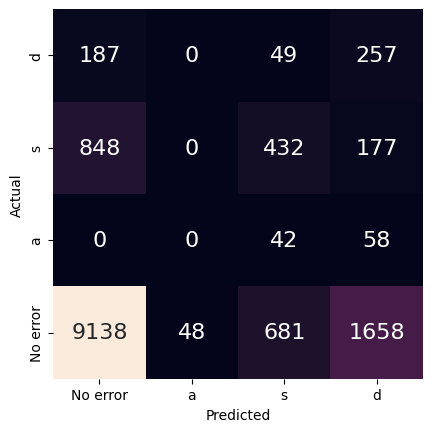

In [ ]:
print(classification_report(y_true, y_pred))
labels = ["No error", "a", "s", "d"]
cm = confusion_matrix(y_true, y_pred,labels=labels)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.invert_yaxis() #optional
plt.show()